In [1]:
cd ..

/mnt/WD_Blue/Machine_Learning/Proyectos/Chatbot-en-Espanol


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pickle, random, itertools, os, math
import numpy as np
import matplotlib.pyplot as plt

from pre_processing import Voc
from transformer import Transformer, create_masks
from settings import *

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

ModuleNotFoundError: No module named 'pre_processing'

## Loading data and batching

In [3]:
save_dir='data/Transformer_500k_UNK'

In [4]:
with open(save_dir + '/voc.pkl',  'rb') as f:
    voc   = pickle.load(f)
voc_size = voc.num_words

with open(save_dir + '/pairs.pkl','rb') as f:
    pairs = pickle.load(f)
    
with open("./data/loss_log.pkl", 'rb') as f:
    loss_log = pickle.load(f)

In [5]:
# # sentencepiece
# import sentencepiece as spm

# with open(save_dir + '/sp_pairs.pkl','rb') as f:
#     pairs = pickle.load(f)
    
# with open("./data/loss_log.pkl", 'rb') as f:
#     loss_log = pickle.load(f)

# sp = spm.SentencePieceProcessor()
# sp.load(f'{save_dir}/m_bpe.model')
# voc_size = sp.get_piece_size()

In [6]:
def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Returns padded input sequence tensor and lengths
def inputVar(indexes_batch):
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(indexes_batch):
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    
    mask = binaryMatrix(padList)
    mask = torch.ByteTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(pair_batch):
    pair_batch.sort(key=lambda x: len(x[0]), reverse=True) #orden por len of inp
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append([SOS_token]+pair[1])
    inp, lengths = inputVar(input_batch)
    output, mask, max_target_len = outputVar(output_batch)
    return inp, lengths, output, mask, max_target_len

In [7]:
# Example for validation
small_batch_size = 6
pairs_list = [random.choice(pairs) for _ in range(small_batch_size)]
batches = batch2TrainData(pairs_list)
input_variable, lengths, target_variable, mask, max_target_len = batches
#only input_variable and target_variable used for transformer

print("input_variable:\n", input_variable) #(sl,bs)
print("lengths:", lengths)
print("target_variable:\n", target_variable)
print("mask:\n", mask)
print("max_target_len:", max_target_len)

input_variable:
 tensor([[   33,    66,   366,    31,     3,   148],
        [ 1764,   194,    44,    47,  2073,     7],
        [13311,   287,   196,  1005, 10120,     2],
        [   40,  1786, 10588,  1066,     7,     0],
        [  963,   452,     7,    37,     2,     0],
        [   14,     7,     2,     2,     0,     0],
        [ 1005,     2,     0,     0,     0,     0],
        [  663,     0,     0,     0,     0,     0],
        [  665,     0,     0,     0,     0,     0],
        [  406,     0,     0,     0,     0,     0],
        [    7,     0,     0,     0,     0,     0],
        [    2,     0,     0,     0,     0,     0]])
lengths: tensor([12,  7,  6,  6,  5,  3])
target_variable:
 tensor([[    1,     1,     1,     1,     1,     1],
        [  148,   173,   148,    27,    92,    92],
        [    7,    33,     7,  1160,  1109,   223],
        [    2,  1370,     2,  2737,  1255,     7],
        [    0, 12397,     0,    40,    33,     7],
        [    0, 12398,     0,  5916,  

## Modelo

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
d_model = 512 #original 512
heads = 8
N = 6 #original 6
src_vocab = trg_vocab = voc_size
model = Transformer(src_vocab, trg_vocab, d_model, N, heads,0.1)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
# this code is very important! It initialises the parameters with a
# range of values that stops the signal fading or getting too big.
# See this blog for a mathematical explanation.
optim = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9)

In [10]:
count_parameters(model)

65292738

In [11]:
model = model.to(device)

## Training

In [12]:
def plot_loss(d):
    x,y=[],[]
    for k,v in d.items():
            x.append(k)
            y.append(v)
    plt.plot(x,y)

In [13]:
def train_model(n_iteration, batch_size, total_iter, print_every=1000,save_every=1000):
    
    start_iteration = 0
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration']
    
    model.train()
    total_loss = 0
    
    training_batches = [batch2TrainData([random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]
    
    for iteration in range(1,n_iteration+1):
        training_batch = training_batches[iteration-1]       
        inp, _, tar, _, _ = training_batch  
        src = inp.transpose(0,1)
        trg = tar.transpose(0,1)
        
        # the last, as it is using each word to predict the next
        trg_input = trg[:, :-1]
        targets = trg[:, 1:].contiguous().view(-1) # the words we are trying to predict
        
        src = src.to(device)
        trg_input = trg_input.to(device)
        targets = targets.to(device)
        
        preds = model(src, trg_input)
        optim.zero_grad()

        loss = F.cross_entropy(preds.view(-1, preds.size(-1)),
        targets, ignore_index=PAD_token)
        loss.backward()
        optim.step()

        total_loss += loss.item()
        if (iteration + 1) % print_every == 0:
            loss_avg = total_loss / print_every
            loss_dict[total_iter+iteration] = loss_avg
            print(f"iter {iteration + 1}, loss = {loss_avg:.3f}")
            plot_loss(loss_dict)
            total_loss = 0
    
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, "checkpoints")
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': start_iteration+iteration,
                'params': model.state_dict(),
                'opt': optim.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                "total_iter": total_iter+iteration,
                'loss': loss_dict #for plotting
            }, os.path.join(directory, 'transformer_checkpoint.tar'))
    
    
    with open("./data/loss_log.pkl", 'wb') as f:
        loss_log['transformer_2_5m'] = loss_dict
        pickle.dump(loss_log, f)

In [14]:
train_from_zero = True
load_last_iter  = False
chkpt_dir = os.path.join(save_dir, "checkpoints")

if train_from_zero:
    loadFilename = None
    total_iter = 0
    loss_dict = {}
else:
    if load_last_iter: #load last save
        chkpt = os.listdir(chkpt_dir)[-1]
        loadFilename = os.path.join(chkpt_dir,chkpt)
    else:    
        checkpoint_iter = 10_000 #load especific iter
        loadFilename = os.path.join(chkpt_dir, 'transformer_checkpoint.tar')
# load thigs
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))+
    model.load_state_dict(checkpoint['params'])
    voc.__dict__ = checkpoint['voc_dict']
    total_iter = checkpoint["total_iter"]
    loss_dict = checkpoint["loss"]
    optim.load_state_dict(checkpoint['opt'])

In [15]:
iters = 10_000
bs = 64
print_every = 1_000
save_every = 11_000

In [ ]:
%%time
train_model(iters,bs,total_iter,print_every,save_every)

OpenSubtitle_PUNCT3_UNK
OpenSubtitle_P3_500k_WT_UNK
transformer


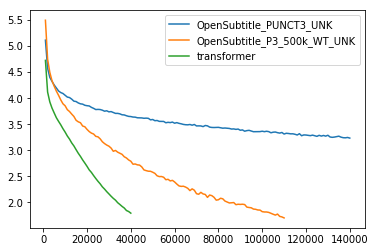

In [233]:
ls = ['OpenSubtitle_PUNCT3_UNK', 'OpenSubtitle_P3_500k_WT_UNK', 'transformer']
for l in ls:
    print(l)
    plot_loss(loss_log[l])
    plt.gca().legend(ls)

In [124]:
# l = list(loss_log.keys())
# for k,v in loss_log.items():
#     plot_loss(v)
#     plt.gca().legend(l)

## Eval 

In [26]:
import re
from pre_processing import process_punct, indexesFromSentence

In [27]:
def custom_capitalize(s):
    for i, c in enumerate(s):
        if c.isalpha():
            break
    return s[:i] + s[i:].capitalize()

In [28]:
def reformatString(l):
    s = l.strip().lower()
#     s = re.sub(r"<guion_inic>",r"", s)
    s = re.sub(r"\s+([.!?])", r"\1", s)
    s = re.sub(r"([¡¿])\s+", r"\1", s)
    s = re.sub(r"\s+", r" ", s)
    return custom_capitalize(s).strip()

In [29]:
#GreedySearch
def GreedySearchTransform(model, src):
    src_mask = (src != PAD_token).unsqueeze(-2)
    e_outputs= model.encoder(src, src_mask)

    outputs = torch.zeros(MAX_LENGTH).type_as(src.data)
    outputs[0] = torch.LongTensor([SOS_token])
    
    for i in range(1, MAX_LENGTH):
        trg_mask = nopeak_mask(i).cuda()

        out = model.out(model.decoder(outputs[:i].unsqueeze(0),e_outputs, src_mask, trg_mask))
        out = F.softmax(out, dim=-1)
        val, ix = out[:, -1].data.topk(1)

        outputs[i] = ix[0][0]
                           
        if ix[0][0] == EOS_token:
            break
                           
    return outputs

In [30]:
def init_vars(src, model, k):
    src_mask = (src != PAD_token).unsqueeze(-2)
    e_output = model.encoder(src, src_mask)
    
    frst_dec_inp = torch.LongTensor([[SOS_token]]).cuda()
    trg_mask = nopeak_mask(1).cuda()
    
    out = model.out(model.decoder(frst_dec_inp, e_output, src_mask, trg_mask))
    out = F.softmax(out, dim=-1) #(bs,sl,voc_size)
    
    probs, ix = out[:, -1].data.topk(k) #(1,k)
    log_scores = torch.Tensor([math.log(prob) for prob in probs.data[0]]).unsqueeze(0) #(1,k)
   
    k_outs = torch.zeros(k, MAX_LENGTH).long().cuda()
    
    k_outs[:, 0] = SOS_token
    k_outs[:, 1] = ix[0] #first col with all the first k words
    
    e_outputs = torch.zeros(k, e_output.size(-2),e_output.size(-1)).cuda()
    e_outputs[:, :] = e_output[0]
    
    return k_outs, e_outputs, log_scores

def k_best_outputs(k_outs, out, log_scores, i, k):
    
    probs, ix = out[:, -1].data.topk(k)
    log_probs = torch.Tensor([math.log(p) for p in probs.data.view(-1)]).view(k, -1) + log_scores.transpose(0,1)
    k_probs, k_ix = log_probs.view(-1).topk(k)
    
    row = k_ix // k
    col = k_ix % k

    k_outs[:, :i] = k_outs[row, :i]
    k_outs[:, i] = ix[row, col]

    log_scores = k_probs.unsqueeze(0)
    
    return k_outs, log_scores

def beam_search(model, src, k=10):
    
    k_outs, e_outputs, log_scores = init_vars(src, model, k)
    src_mask = (src != PAD_token).unsqueeze(-2)
    ind = 0
    score= torch.tensor([[1 for i in range(k)]]).float()
    for i in range(2, MAX_LENGTH):
        trg_mask = nopeak_mask(i).cuda()
        out = model.out(model.decoder(k_outs[:,:i],e_outputs, src_mask, trg_mask))
        out = F.softmax(out, dim=-1)

        k_outs, log_scores = k_best_outputs(k_outs, out, log_scores, i, k)
        
        finish_outs = len(set((k_outs==EOS_token).nonzero()[:,0].cpu().numpy()))
        if finish_outs == k:
            break

    alpha = 0.7
    
    x = (k_outs==EOS_token).nonzero()
    EOS_idx = []
    out_idx=0
    for i in range(len(x)):
        if x[i][0] == out_idx:
            EOS_idx.append(i)
            out_idx+=1
    out_lens = x[EOS_idx][:,1]
    div = 1/(out_lens.type_as(log_scores)**alpha)
    score = log_scores * div
    _, ind = torch.max(score, 1)
    ind = ind.data[0]
    
    out = k_outs[random.choices([i for i in range(k)], torch.exp(score[0]))]
    length = (out[0]==EOS_token).nonzero()[0]
    out = out[0][1:length]

    return out

In [31]:
sentence = process_punct("hola.".encode()).split()
print(sentence)
indexes_batch = [indexesFromSentence(sentence, voc)] #list of tokens
# Transpose dimensions of batch to match models' expectations
src = torch.LongTensor(indexes_batch).cuda()

# tokens=GreedySearchTransform(model,input_batch,50)
out = beam_search(model,src,10)

output_words = [voc.index2word[token.item()] for token in out]
output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
raw_ans = ' '.join(output_words)
ans = reformatString(raw_ans)
ans

['hola', '.']


'¿Cómo está?'

In [32]:
def evaluate(model, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    sentence = sentence.split()
    indexes_batch = [indexesFromSentence(sentence, voc)] #list of tokens
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).cuda() #(bs=1,seq_len)
    # Decode sentence with searcher
    tokens = searcher(model, input_batch)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words

#bot cycle, receive input and outputs answer
def evaluateInput(model, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
#             input_sentence = "-"+input_sentence #para que siga el formato de guiones de una conversacion
            input_sentence = process_punct(input_sentence.encode())
            # Evaluate sentence
            output_words = evaluate(model, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x =='SOS' or x == 'EOS' or x == 'PAD')]
            raw_ans = ' '.join(output_words)
            ans = reformatString(raw_ans)
            print('Bot:',ans)

        except KeyError:
            print("Error: Encountered unknown word.")

In [33]:
# Set dropout layers to eval mode
model.eval()

# Initialize search module
# searcher = GreedySearchTransform
searcher = beam_search

# Begin chatting (uncomment and run the following line to begin)
evaluateInput(model, searcher, voc)

> hola.
Bot: Hola.
> hola.
Bot: ¡Hola!
> hola.
Bot: ¿Cómo está?
> yo bien, ¿y tú?
Bot: Sí.
> bueno me alegro.
Bot: Me alegro mucho de verte.
> si claro..
Bot: Gracias.
> de nada.
Bot: Buenas noches.
> adiós
Bot: Adiós...
> no quiero irme.
Bot: ¿A dónde va?
> a robar carteras.
Bot: ¿Está loco?
> solo un poco.
Bot: No.
> bueno vale.
Bot: Buenas noches.
> ¡que no me voy!
Bot: ¡Le voy a matar!
> inténtalo.
Bot: Tampoco lo prometo.
> no te eches atrás ahora.
Bot: Por favor jessica.
> no me llamo jessica.
Bot: No la llevo encima.
> ¿la pistola?
Bot: Quiero hablar con usted.
> ¿de qué?
Bot: Creí que había dicho algo.
> q
